In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib import rc

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import sys
import math
import pickle


import itertools

from scipy.optimize import curve_fit

In [36]:
#data

num_variables_list = [str(num).zfill(3) for num in range(10,24, 2)] 
# graph_type_list = [ '3regular', '050', '070', '080', '090', '095', '100','complete']
graph_type_list = ['complete']

r_list = range(100)
tau_list =[0.3] # [0.3, 0.4]
alpha_list = [0.01]
layer = 1
shots = None
tot_steps = range(5)


color_map = {
    "3regular": "blue",
    "050": "red",
    "070": "purple",
    "080": "orange",
    "090": "cyan",
    "095": "pink",
    "complete": "green",
}


color_map = {
    "22": "blue",
    "20": "red",
    "18": "purple",
    "16": "orange",
    "14": "cyan",
    "12": "pink",
    "10": "green",
}


In [38]:
#initialize empty dictionaries

entropy_results_dict = {f'{abs}' : {
f'{nqubits}' : {f'{graph}': [0,0] for graph in graph_type_list} for nqubits in num_variables_list} for abs in [True, False]}
print(entropy_results_dict)

cvar_results_dict =  {f'{abs}' : {
f'{nqubits}' : {f'{graph}': [0,0] for graph in graph_type_list} for nqubits in num_variables_list} for abs in [True, False]}
print(cvar_results_dict)

fidelity_results_dict =  {f'{abs}' : {
f'{nqubits}' : {f'{graph}': [[0,0],[0,0],[0,0]] for graph in graph_type_list} for nqubits in num_variables_list} for abs in [True, False]}
print(fidelity_results_dict)

{'True': {'010': {'complete': [0, 0]}, '012': {'complete': [0, 0]}, '014': {'complete': [0, 0]}, '016': {'complete': [0, 0]}, '018': {'complete': [0, 0]}, '020': {'complete': [0, 0]}, '022': {'complete': [0, 0]}}, 'False': {'010': {'complete': [0, 0]}, '012': {'complete': [0, 0]}, '014': {'complete': [0, 0]}, '016': {'complete': [0, 0]}, '018': {'complete': [0, 0]}, '020': {'complete': [0, 0]}, '022': {'complete': [0, 0]}}}
{'True': {'010': {'complete': [0, 0]}, '012': {'complete': [0, 0]}, '014': {'complete': [0, 0]}, '016': {'complete': [0, 0]}, '018': {'complete': [0, 0]}, '020': {'complete': [0, 0]}, '022': {'complete': [0, 0]}}, 'False': {'010': {'complete': [0, 0]}, '012': {'complete': [0, 0]}, '014': {'complete': [0, 0]}, '016': {'complete': [0, 0]}, '018': {'complete': [0, 0]}, '020': {'complete': [0, 0]}, '022': {'complete': [0, 0]}}}
{'True': {'010': {'complete': [[0, 0], [0, 0], [0, 0]]}, '012': {'complete': [[0, 0], [0, 0], [0, 0]]}, '014': {'complete': [[0, 0], [0, 0], [0,

qubits =  10 graph complete
here 10 green
here 10 green
here 10 green
here 10 green
here 10 green
qubits =  12 graph complete
here 12 pink
here 12 pink
here 12 pink
here 12 pink
here 12 pink
qubits =  14 graph complete
here 14 cyan
here 14 cyan
here 14 cyan
here 14 cyan
here 14 cyan
qubits =  16 graph complete
here 16 orange
here 16 orange
here 16 orange
here 16 orange
here 16 orange
qubits =  18 graph complete
here 18 purple
here 18 purple
here 18 purple
here 18 purple
here 18 purple
qubits =  20 graph complete
here 20 red
here 20 red
here 20 red
here 20 red
here 20 red
qubits =  22 graph complete
here 22 blue
here 22 blue
here 22 blue
here 22 blue
here 22 blue
qubits =  10 graph complete
here 10 green
here 10 green
here 10 green
here 10 green
here 10 green
qubits =  12 graph complete
here 12 pink
here 12 pink
here 12 pink
here 12 pink
here 12 pink
qubits =  14 graph complete
here 14 cyan
here 14 cyan
here 14 cyan
here 14 cyan
here 14 cyan
qubits =  16 graph complete
here 16 orange
he

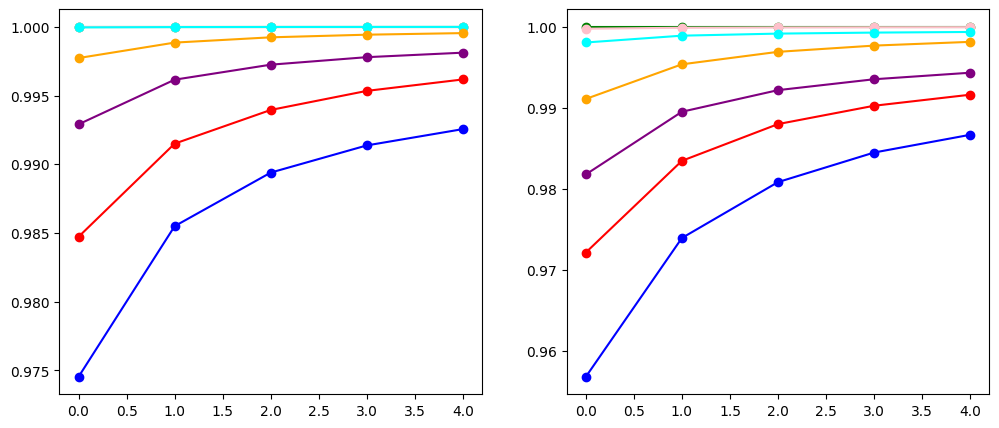

In [53]:
#fill dictionaries with data from files

f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

for if_adsorting in [True, False]:  #CHANGE LATER!!!!!!!
    
    for graph in graph_type_list:

        dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                                .format(graph,  shots)

        for n_qubits_i, num_variables in enumerate(num_variables_list):
            N = int(num_variables)
            
            if graph == 'complete':
                num_params = int(2*(N-1)*N/2 + N)
            elif graph == '3regular':
                num_params= int(2*(3*N)/2 + N)
            elif graph == '100':
                density = 1
                num_params = 2*round((N-1)*N*density/2) +N
            else:
                density = float(f"0.{int(graph)}")
                num_params = 2*round(density*(N-1)*N/2 + 1e-15) +N

            print("qubits = ", N, 'graph', graph)
                
            for alpha in alpha_list:

                for taui, tau in enumerate(tau_list):
                    
                    #print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N, "parameters =", num_params)
                    
                    dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                        .format(num_variables, num_params, layer, alpha)
                    
                    successes = np.zeros((3, len(r_list)))
                    max_entros = []
                    cvarvalues = []

                    cvar_passi = []

                    for passo in tot_steps: 

                        for r in r_list:
                            
                            file_dir_name = dir_name + '/r_{}'\
                                        .format(r)
                            
                            filename = file_dir_name + '/ifadsorting_{}_tau_{}.pkl'\
                                                                    .format(if_adsorting,tau)
                            with open(filename, 'rb') as f:
                                data = pickle.load(f)

                            params_list = data["params_list"]
                            if len(params_list) != round(num_params):
                                print("error N, r = ", r, len(params_list))
                                
                            steps_exp_poss_dict = data["steps_exp_poss_dict"]
                            steps_cvar_dict = data["steps_cvar_dict"]
                            steps_entropy_dict = data["steps_entropy_dict"]
                            
                            final_exp_poss = steps_exp_poss_dict[f"step_{passo}"]["l_1"]
                            poss_list = list(final_exp_poss.values())

                            if poss_list[0] > alpha:
                                successes[0][r] = 1
                            if sum(poss_list[:2]) > alpha:
                                successes[1][r] = 1
                            if sum(poss_list[:3]) > alpha:
                                successes[2][r] = 1

                            exp_opt = list(final_exp_poss.keys())[0]
                            cvar = steps_cvar_dict[f"step_{passo}"]
                            cvarvalues.append(cvar/exp_opt)

                            # max_key = max(steps_entropy_dict, key=steps_entropy_dict.get)
                            # max_entros.append(steps_entropy_dict[max_key])
                        
                        for i in range(3):
                            fidelity_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][i][0] = np.mean(successes[i])
                            fidelity_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][i][1] = np.std(successes[i], axis=0, ddof=1)

                        cvar_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][0] = np.mean(cvarvalues)
                        cvar_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][1] = np.std(cvarvalues, axis=0, ddof=1)

                        cvar_passi.append(np.mean(cvarvalues))
                        c = str(N)
                        color = color_map.get(c, "black")
                        print('here', str(N), color)
                        
                        # if if_adsorting:
                        #     ax1.plot(passo + 1, np.mean(cvarvalues), "o-", color = color, label = f'{num_variables}, {if_adsorting}, {shots}')
                        # else:
                        #     ax2.plot(passo + 1, np.mean(cvarvalues), "o-", color = color, label = f'{num_variables}, {if_adsorting}, {shots}')

                if if_adsorting:
                    ax1.plot(tot_steps, cvar_passi, "o-", color = color, label = f'{num_variables}, {if_adsorting}, {shots}')
                else:
                    ax2.plot(tot_steps, cvar_passi, "o-", color = color, label = f'{num_variables}, {if_adsorting}, {shots}')

                        # ax2.plot(passo +1 , np.mean(cvarvalues), "o:", label = f'{num_variables}, {if_adsorting}, {shots}')

                    # entropy_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][0] = np.mean(max_entros)
                    # entropy_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][1] = np.std(max_entros, axis=0, ddof=1)

qubits =  10 graph complete
here 10 green
here 10 green
here 10 green
here 10 green
here 10 green
qubits =  12 graph complete
here 12 pink
here 12 pink
here 12 pink
here 12 pink
here 12 pink
qubits =  14 graph complete
here 14 cyan
here 14 cyan
here 14 cyan
here 14 cyan
here 14 cyan
qubits =  16 graph complete
here 16 orange
here 16 orange
here 16 orange
here 16 orange
here 16 orange
qubits =  18 graph complete
here 18 purple
here 18 purple
here 18 purple
here 18 purple
here 18 purple
qubits =  20 graph complete
here 20 red
here 20 red
here 20 red
here 20 red
here 20 red
qubits =  22 graph complete
here 22 blue
here 22 blue
here 22 blue
here 22 blue
here 22 blue
qubits =  10 graph complete
here 10 green
here 10 green
here 10 green
here 10 green
here 10 green
qubits =  12 graph complete
here 12 pink
here 12 pink
here 12 pink
here 12 pink
here 12 pink
qubits =  14 graph complete
here 14 cyan
here 14 cyan
here 14 cyan
here 14 cyan
here 14 cyan
qubits =  16 graph complete
here 16 orange
he

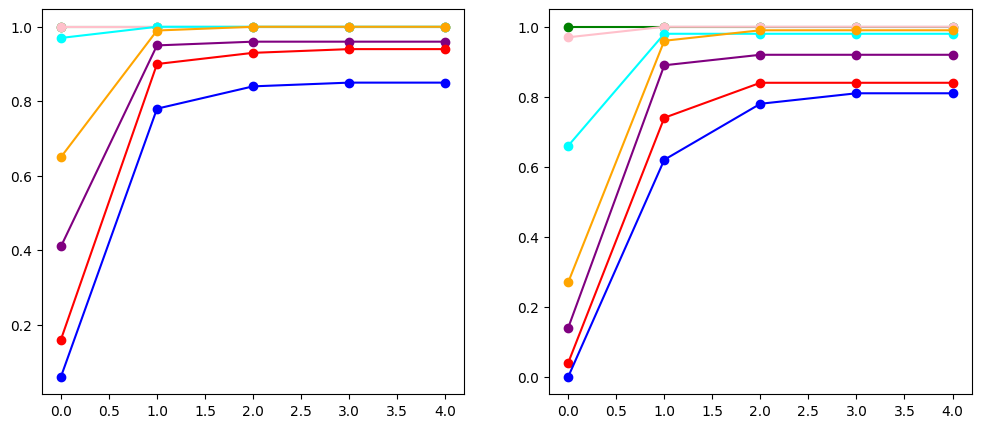

In [54]:
#fill dictionaries with data from files

f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

for if_adsorting in [True, False]:  #CHANGE LATER!!!!!!!
    
    for graph in graph_type_list:

        dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                                .format(graph,  shots)

        for n_qubits_i, num_variables in enumerate(num_variables_list):
            N = int(num_variables)
            
            if graph == 'complete':
                num_params = int(2*(N-1)*N/2 + N)
            elif graph == '3regular':
                num_params= int(2*(3*N)/2 + N)
            elif graph == '100':
                density = 1
                num_params = 2*round((N-1)*N*density/2) +N
            else:
                density = float(f"0.{int(graph)}")
                num_params = 2*round(density*(N-1)*N/2 + 1e-15) +N

            print("qubits = ", N, 'graph', graph)
                
            for alpha in alpha_list:

                for taui, tau in enumerate(tau_list):
                    
                    #print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N, "parameters =", num_params)
                    
                    dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                        .format(num_variables, num_params, layer, alpha)
                    
                    successes = np.zeros((3, len(r_list)))
                    max_entros = []
                    cvarvalues = []

                    cvar_passi = []

                    for passo in tot_steps: 

                        for r in r_list:
                            
                            file_dir_name = dir_name + '/r_{}'\
                                        .format(r)
                            
                            filename = file_dir_name + '/ifadsorting_{}_tau_{}.pkl'\
                                                                    .format(if_adsorting,tau)
                            with open(filename, 'rb') as f:
                                data = pickle.load(f)

                            params_list = data["params_list"]
                            if len(params_list) != round(num_params):
                                print("error N, r = ", r, len(params_list))
                                
                            steps_exp_poss_dict = data["steps_exp_poss_dict"]
                            steps_cvar_dict = data["steps_cvar_dict"]
                            steps_entropy_dict = data["steps_entropy_dict"]
                            
                            final_exp_poss = steps_exp_poss_dict[f"step_{passo}"]["l_1"]
                            poss_list = list(final_exp_poss.values())

                            if poss_list[0] > alpha:
                                successes[0][r] = 1
                            if sum(poss_list[:2]) > alpha:
                                successes[1][r] = 1
                            if sum(poss_list[:3]) > alpha:
                                successes[2][r] = 1

                            exp_opt = list(final_exp_poss.keys())[0]
                            cvar = steps_cvar_dict[f"step_{passo}"]
                            cvarvalues.append(cvar/exp_opt)

                            # max_key = max(steps_entropy_dict, key=steps_entropy_dict.get)
                            # max_entros.append(steps_entropy_dict[max_key])
                        
                        for i in range(3):
                            fidelity_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][i][0] = np.mean(successes[i])
                            fidelity_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][i][1] = np.std(successes[i], axis=0, ddof=1)

                        cvar_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][0] = np.mean(cvarvalues)
                        cvar_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][1] = np.std(cvarvalues, axis=0, ddof=1)

                        cvar_passi.append(np.mean(successes[0]))
                        c = str(N)
                        color = color_map.get(c, "black")
                        print('here', str(N), color)
                        
                        # if if_adsorting:
                        #     ax1.plot(passo + 1, np.mean(cvarvalues), "o-", color = color, label = f'{num_variables}, {if_adsorting}, {shots}')
                        # else:
                        #     ax2.plot(passo + 1, np.mean(cvarvalues), "o-", color = color, label = f'{num_variables}, {if_adsorting}, {shots}')

                if if_adsorting:
                    ax1.plot(tot_steps, cvar_passi, "o-", color = color, label = f'{num_variables}, {if_adsorting}, {shots}')
                else:
                    ax2.plot(tot_steps, cvar_passi, "o-", color = color, label = f'{num_variables}, {if_adsorting}, {shots}')

                        # ax2.plot(passo +1 , np.mean(cvarvalues), "o:", label = f'{num_variables}, {if_adsorting}, {shots}')

                    # entropy_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][0] = np.mean(max_entros)
                    # entropy_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][1] = np.std(max_entros, axis=0, ddof=1)

In [24]:
print(color_map.get(f'{str(N)}'))

None


In [33]:
c = str(N)
print(color_map.get(c))
print(c)

blue
22
